
#  Pneumonia Classification from Chest X-Rays — CNN

This notebook implements a **from-scratch CNN** for the Kaggle dataset:  
**Pneumonia Chest X-ray**: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

**What you get:**
- Colab-friendly setup (works with CPU, **CUDA**, and Apple **MPS** if you run locally).
- Clean data pipeline (train/val/test; Kaggle split kept **intact**).
- Custom CNN model (PyTorch) + early stopping + LR scheduler.
- Metrics: accuracy, precision, recall, F1, AUROC; confusion matrix.
- Plots for training curves.
- Optional **ResNet18 transfer learning** baseline (still a CNN).
- Final **test** evaluation is reported **once** at the end.


In [20]:

# If running in Colab: uncomment to make sure packages are available.
# On local Mac (MPS), these installs also work with Python 3.10+.
# In Colab, torch/torchvision often preinstalled. Safe to re-run if needed.

# !pip install -q torch torchvision torchaudio
# !pip install -q scikit-learn matplotlib tqdm kaggle

import os, sys, platform, subprocess, json, shutil, zipfile, tarfile
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)

print("Python:", sys.version)
print("Torch :", torch.__version__)
print("Torch CUDA available:", torch.cuda.is_available())
print("MPS available:", hasattr(torch.backends, "mps") and torch.backends.mps.is_available())

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)


Python: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
Torch : 2.8.0
Torch CUDA available: False
MPS available: True
Using device: mps


In [21]:
#from pathlib import Path
#import os, json

# <<< FILL THESE >>>
#KAGGLE_USERNAME = "fouadazem"   # from kaggle.json file
#KAGGLE_KEY = "9775b3c2c7f95b17b1f5cfd75f72d4c1"         # from kaggle.json file

# Path to Final_Project/Data/kaggle.json (relative to where notebook runs in notebooks/)
#cfg_dir = Path.cwd().parent / "Data"
#cfg_dir.mkdir(exist_ok=True)  # ensure Data exists
#cfg_path = cfg_dir / "kaggle.json"

# Write kaggle.json into Data/
#cfg = {"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}
#cfg_path.write_text(json.dumps(cfg))
#os.chmod(cfg_path, 0o600)

# Also copy it to ~/.kaggle so the CLI can find it
#home_kaggle_dir = Path.home() / ".kaggle"
#home_kaggle_dir.mkdir(exist_ok=True)
#home_cfg_path = home_kaggle_dir / "kaggle.json"
#home_cfg_path.write_text(json.dumps(cfg))
#os.chmod(home_cfg_path, 0o600)

# Set environment variables for this session (optional)
#os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
#os.environ["KAGGLE_KEY"] = KAGGLE_KEY

#print(f"Saved kaggle.json to: {cfg_path}")
#print(f"Copied kaggle.json to: {home_cfg_path}")
#print("Permissions (home copy):", oct(home_cfg_path.stat().st_mode)[-3:])



## 1) Get the dataset

This notebook expects the Kaggle folder structure:

```
chest_xray/
  train/NORMAL, train/PNEUMONIA
  val/NORMAL,   val/PNEUMONIA
  test/NORMAL,  test/PNEUMONIA
```

### Option A (Recommended): Kaggle API (automated)
1. Get your Kaggle API token from https://www.kaggle.com/account (download `kaggle.json`).
2. Upload `kaggle.json` in the next cell when prompted (Colab: left sidebar → Files → Upload).

### Option B: Manual upload
- Upload the extracted `chest_xray/` folder into the working directory (e.g., `/content/chest_xray`).

The next cell will:
- Try to **detect** `chest_xray/`.
- If not found and `kaggle.json` exists, it will **download** and **extract** automatically.


In [22]:
from pathlib import Path
import os, shutil, subprocess

# Current working directory is notebooks/, so go up one level to Final_Project/
DATASET_DIR = Path.cwd().parent / "Data" / "chest_xray"
KAGGLE_ZIP = DATASET_DIR.parent / "chest-xray-pneumonia.zip"

def has_dataset_structure(root: Path) -> bool:
    return (root / "train").exists() and (root / "val").exists() and (root / "test").exists()

def try_kaggle_download():
    kaggle_json_candidates = [Path("./kaggle.json"), Path("/content/kaggle.json")]
    for cand in kaggle_json_candidates:
        if cand.exists():
            os.makedirs(Path.home() / ".kaggle", exist_ok=True)
            shutil.copy(str(cand), str(Path.home() / ".kaggle/kaggle.json"))
            os.chmod(Path.home() / ".kaggle/kaggle.json", 0o600)
            break

    try:
        print("Attempting Kaggle download...")
        subprocess.run(
            ["kaggle", "datasets", "download", "-d", "paultimothymooney/chest-xray-pneumonia", "-p", str(DATASET_DIR.parent)],
            check=True
        )
        if KAGGLE_ZIP.exists():
            print("Extracting zip...")
            shutil.unpack_archive(str(KAGGLE_ZIP), str(DATASET_DIR.parent))
    except Exception as e:
        print("Kaggle download failed:", e)

if not has_dataset_structure(DATASET_DIR):
    print("Dataset folder not found at", DATASET_DIR.resolve())
    if shutil.which("kaggle") is None:
        print("Kaggle CLI not found. Install with `pip install kaggle` and rerun, or upload chest_xray/ manually.")
    else:
        try_kaggle_download()

print("Dataset present?", has_dataset_structure(DATASET_DIR), "->", DATASET_DIR.resolve())
if not has_dataset_structure(DATASET_DIR):
    print("❗ Please upload the `chest_xray/` folder (with train/val/test).")


Dataset present? True -> /Users/fouadaz/LearningFromUniversity/Learning/DeepLearning/DeepLearning_2025/FinalProject/Deep_Learning_Assignments/Final_Project/Data/chest_xray



## 2) Inspect the data (counts, examples, image sizes)


Image counts by split and class:
 train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
 val: {'NORMAL': 8, 'PNEUMONIA': 8}
 test: {'NORMAL': 234, 'PNEUMONIA': 390}


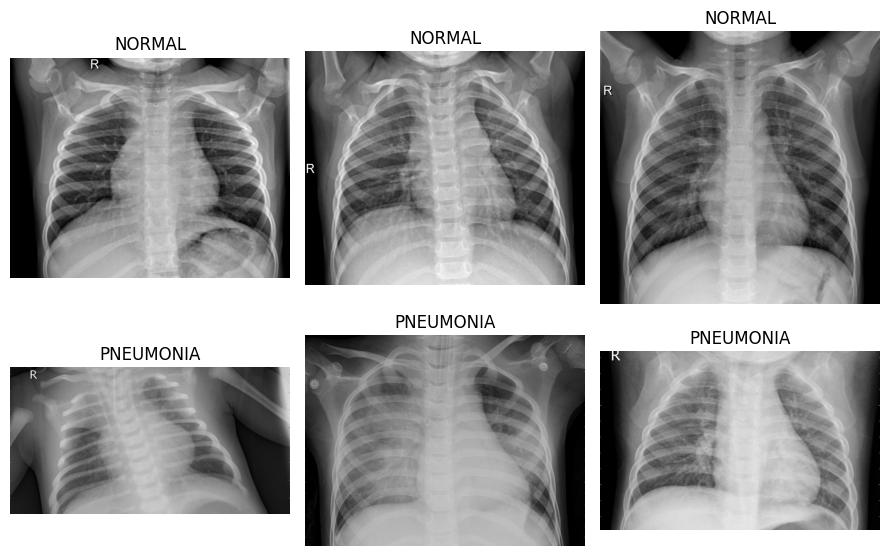

Sampled 416 images
Width:  mean=1384.0, min=445, max=2772
Height: mean=1019.7, min=177, max=2540


In [23]:

from collections import defaultdict
from PIL import Image

def count_images(root: Path):
    counts = {}
    for split in ["train", "val", "test"]:
        split_root = root / split
        split_counts = {}
        if split_root.exists():
            for cls in sorted([d for d in split_root.iterdir() if d.is_dir()]):
                split_counts[cls.name] = len(list(cls.glob("**/*.*")))
        counts[split] = split_counts
    return counts

def show_grid_of_images(root: Path, split="train", n=6):
    split_root = root / split
    classes = sorted([d for d in split_root.iterdir() if d.is_dir()])
    files = []
    for c in classes:
        files.extend(random.sample(list(c.glob("**/*.*")), k=min(n//len(classes) or 1, len(list(c.glob('**/*.*'))))))
    files = files[:n]
    cols = min(n, 3)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(3*cols, 3*rows))
    for i, f in enumerate(files, 1):
        ax = plt.subplot(rows, cols, i)
        img = Image.open(f).convert("L")
        ax.imshow(img, cmap="gray")
        ax.set_title(f.parent.name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def image_size_stats(root: Path, sample_k=200):
    sizes = []
    for split in ["train", "val", "test"]:
        split_root = root / split
        if not split_root.exists():
            continue
        files = list(split_root.glob("**/*.*"))
        random.shuffle(files)
        for f in files[:sample_k]:
            try:
                with Image.open(f) as im:
                    sizes.append(im.size)  # (W, H)
            except:
                pass
    if sizes:
        arr = np.array(sizes)
        w, h = arr[:,0], arr[:,1]
        print(f"Sampled {len(sizes)} images")
        print(f"Width:  mean={w.mean():.1f}, min={w.min()}, max={w.max()}")
        print(f"Height: mean={h.mean():.1f}, min={h.min()}, max={h.max()}")
    else:
        print("No images found to sample.")

if has_dataset_structure(DATASET_DIR):
    counts = count_images(DATASET_DIR)
    print("Image counts by split and class:")
    for split, d in counts.items():
        print(f" {split}: {d}")
    show_grid_of_images(DATASET_DIR, "train", n=6)
    image_size_stats(DATASET_DIR, sample_k=200)


In [24]:
import os, random
import numpy as np
import matplotlib.pyplot as plt

print("DATASET_DIR =", DATASET_DIR.resolve())
print("Exists? ", DATASET_DIR.exists())
print("train exists? ", (DATASET_DIR/"train").exists())
print("val exists?   ", (DATASET_DIR/"val").exists())
print("test exists?  ", (DATASET_DIR/"test").exists())


DATASET_DIR = /Users/fouadaz/LearningFromUniversity/Learning/DeepLearning/DeepLearning_2025/FinalProject/Deep_Learning_Assignments/Final_Project/Data/chest_xray
Exists?  True
train exists?  True
val exists?    True
test exists?   True



## 3) Data pipeline (augment train only)
- We use **grayscale** 1-channel tensors and normalize by dataset stats (computed quickly).
- Keep augmentations **mild** (horizontal flip, small rotation, random resized crop).


In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image
import random, torch

IMG_SIZE = 224
BATCH = 32
NUM_WORKERS = 2

# 1) Compute mean/std from train images
def compute_mean_std(root, split="train", max_samples=600):
    files = list((root / split).glob("**/*.*"))
    random.shuffle(files)
    files = files[:max_samples]
    pixels = []
    for f in files:
        try:
            im = Image.open(f).convert("L").resize((IMG_SIZE, IMG_SIZE))
            arr = np.asarray(im, dtype=np.float32) / 255.0
            pixels.append(arr)
        except:
            pass
    if not pixels:
        return 0.5, 0.25
    arr = np.stack(pixels, axis=0)
    return float(arr.mean()), float(arr.std() + 1e-8)

mean, std = compute_mean_std(DATASET_DIR, "train")
print(f"Norm stats → mean={mean:.4f}, std={std:.4f}")

# 2) Transforms
train_tfms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.08), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.12, p=0.25),
    transforms.ToTensor(),
    transforms.Normalize([mean], [std]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3), value='random'),
])
val_test_tfms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([mean], [std]),
])

# 3) Load full training dataset from train/ and re-split
full_train_dataset = datasets.ImageFolder(DATASET_DIR / "train", transform=train_tfms)

val_ratio = 0.2  # 20% of train goes to validation
val_size = int(len(full_train_dataset) * val_ratio)
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Important: validation dataset should use val_test_tfms, not train_tfms
val_dataset.dataset.transform = val_test_tfms

from torch.utils.data import WeightedRandomSampler
import numpy as np

# Count class frequencies in your TRAIN SPLIT
indices = train_dataset.indices
targets = np.array([full_train_dataset.samples[i][1] for i in indices])  # 0=NORMAL, 1=PNEUMONIA
class_counts = np.bincount(targets)  # e.g., [num_NORMAL, num_PNEUMONIA]
class_weights = 1.0 / class_counts

# Per-sample weight (higher for minority class)
sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),  # ~one pass per epoch
    replacement=True
)
print("Train class counts:", class_counts)


# 4) Test dataset stays as provided
test_dataset = datasets.ImageFolder(DATASET_DIR / "test", transform=val_test_tfms)

# 5) DataLoaders
# Pin memory only helps on CUDA; MPS shows a warning
use_pin = (DEVICE.type == "cuda")

train_dl = DataLoader(train_dataset, batch_size=BATCH, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=use_pin)
val_dl   = DataLoader(val_dataset,   batch_size=BATCH, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=use_pin)

test_dataset = datasets.ImageFolder(DATASET_DIR / "test", transform=val_test_tfms)
test_dl  = DataLoader(test_dataset,  batch_size=BATCH, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=use_pin)

print("Classes:", full_train_dataset.class_to_idx)
print(f"New split → Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")



Norm stats → mean=0.4800, std=0.2365
Train class counts: [1077 3096]
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
New split → Train: 4173 | Val: 1043 | Test: 624



## 4) Custom CNN
Small, fast-to-train architecture with BatchNorm, ReLU, MaxPool, and GAP head.


In [26]:

class PneumoCNN(nn.Module):
    def __init__(self, in_ch=1, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),    nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                    # 112x112

            nn.Conv2d(32, 64, 3, padding=1),    nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),    nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                    # 56x56

            nn.Conv2d(64, 128, 3, padding=1),   nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,128, 3, padding=1),   nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                    # 28x28

            nn.Conv2d(128,256, 3, padding=1),   nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                    # 14x14
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),            # 256 x 1 x 1
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

model = PneumoCNN(in_ch=1, num_classes=2).to(DEVICE)
sum_params = sum(p.numel() for p in model.parameters())
print("Model parameters:", sum_params)
# ---- Optimizer defined here so it's available for training & scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)



Model parameters: 583522



## 5) Train / Validate loops (early stopping + LR scheduler)


In [27]:
# ## 5) Train / Validate loops (early stopping + LR scheduler)

import time
from tqdm import tqdm
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# ---- Decision threshold for class 1 (PNEUMONIA) used in metrics
THRESH = 0.70  # you can overwrite this later (e.g., from your threshold sweep)

# ---- Weighted loss to address imbalance (requires class_counts from loaders cell)
normal_count, pneu_count = int(class_counts[0]), int(class_counts[1])
total = normal_count + pneu_count
# Weight each class roughly by the other class's prevalence
weights = torch.tensor([pneu_count/total, normal_count/total], device=DEVICE, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)
print("Class weights in loss:", [float(w) for w in weights])

# ---- Optimizer should already be defined in the model cell, e.g.:
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# ---- LR scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

def run_epoch(dl, model, train=True, device=DEVICE):
    model.train(train)
    losses, y_true, y_pred, y_scores = [], [], [], []

    for xb, yb in tqdm(dl, disable=False):
        xb, yb = xb.to(device), yb.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        losses.append(loss.item())

        # --- probabilities & thresholded predictions (for metrics only)
        probs = torch.softmax(logits, dim=1)[:, 1]        # tensor on device
        preds = (probs >= THRESH).long()                  # 0/1 tensor

        y_scores.extend(probs.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())
        y_true.extend(yb.detach().cpu().numpy().tolist())

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)

    # AUROC uses scores; may fail if only one class present
    auroc = None
    try:
        auroc = roc_auc_score(y_true, y_scores)
    except Exception:
        pass

    return (float(np.mean(losses)), acc, p, r, f1, auroc)

def plot_single_curve(values, title, ylabel):
    plt.figure()
    plt.plot(values, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


Class weights in loss: [0.741912305355072, 0.258087694644928]



## 6) Train



Epoch 1/30


100%|██████████| 33/33 [00:18<00:00,  1.74it/s]


 Train: loss=0.2095, acc=0.850, p=0.987, r=0.712, f1=0.827, auc=0.9587876003537505
   Val: loss=0.3206, acc=0.810, p=0.995, r=0.750, f1=0.855, auc=0.9742920216283502
  ↳ Saved new best model.

Epoch 2/30


100%|██████████| 33/33 [00:18<00:00,  1.74it/s]


 Train: loss=0.1277, acc=0.902, p=0.986, r=0.812, f1=0.890, auc=0.9857909571798139
   Val: loss=0.3514, acc=0.778, p=0.998, r=0.703, f1=0.825, auc=0.9862440191387559

Epoch 3/30


100%|██████████| 33/33 [00:19<00:00,  1.73it/s]


 Train: loss=0.0902, acc=0.937, p=0.994, r=0.880, f1=0.933, auc=0.9930085816404348
   Val: loss=0.1279, acc=0.953, p=0.985, r=0.951, f1=0.968, auc=0.9932119656124792
  ↳ Saved new best model.

Epoch 4/30


100%|██████████| 33/33 [00:18<00:00,  1.74it/s]


 Train: loss=0.0858, acc=0.941, p=0.992, r=0.892, f1=0.939, auc=0.9935513337280761
   Val: loss=0.3532, acc=0.807, p=1.000, r=0.742, f1=0.852, auc=0.9883737892402847

Epoch 5/30


100%|██████████| 33/33 [00:30<00:00,  1.09it/s]


 Train: loss=0.0687, acc=0.954, p=0.996, r=0.910, f1=0.951, auc=0.9955159103522037
   Val: loss=0.7311, acc=0.886, p=0.867, r=1.000, f1=0.929, auc=0.9902069475240207

Epoch 6/30


100%|██████████| 33/33 [00:19<00:00,  1.72it/s]


 Train: loss=0.0608, acc=0.961, p=0.996, r=0.926, f1=0.960, auc=0.9964685154855619
   Val: loss=0.0738, acc=0.952, p=0.997, r=0.938, f1=0.967, auc=0.996824794802972
  ↳ Saved new best model.

Epoch 7/30


100%|██████████| 33/33 [00:18<00:00,  1.74it/s]


 Train: loss=0.0660, acc=0.955, p=0.995, r=0.916, f1=0.954, auc=0.9959531225594238
   Val: loss=0.0960, acc=0.936, p=0.999, r=0.915, f1=0.955, auc=0.9955265102890263

Epoch 8/30


100%|██████████| 33/33 [00:19<00:00,  1.73it/s]


 Train: loss=0.0609, acc=0.959, p=0.993, r=0.925, f1=0.958, auc=0.996510047744422
   Val: loss=0.1158, acc=0.918, p=1.000, r=0.890, f1=0.942, auc=0.996085696502898

Epoch 9/30


100%|██████████| 33/33 [00:19<00:00,  1.73it/s]


 Train: loss=0.0502, acc=0.968, p=0.997, r=0.937, f1=0.966, auc=0.996907654990861
   Val: loss=0.2074, acc=0.886, p=0.998, r=0.849, f1=0.917, auc=0.9925166297117516

Epoch 10/30


100%|██████████| 33/33 [00:19<00:00,  1.72it/s]


 Train: loss=0.0419, acc=0.971, p=0.997, r=0.947, f1=0.971, auc=0.9984233253201594
   Val: loss=0.1292, acc=0.978, p=0.977, r=0.994, f1=0.985, auc=0.9976951803010852

Epoch 11/30


100%|██████████| 33/33 [00:19<00:00,  1.72it/s]


 Train: loss=0.0262, acc=0.983, p=0.999, r=0.966, f1=0.982, auc=0.9993896836553746
   Val: loss=0.0588, acc=0.983, p=0.994, r=0.983, f1=0.988, auc=0.998254366514957
  ↳ Saved new best model.

Epoch 12/30


100%|██████████| 33/33 [00:19<00:00,  1.73it/s]


 Train: loss=0.0308, acc=0.983, p=1.000, r=0.966, f1=0.982, auc=0.9988363097097619
   Val: loss=0.2079, acc=0.962, p=0.958, r=0.992, f1=0.975, auc=0.9973645310615785

Epoch 13/30


100%|██████████| 33/33 [00:19<00:00,  1.72it/s]


 Train: loss=0.0300, acc=0.980, p=0.999, r=0.960, f1=0.979, auc=0.999046715970976
   Val: loss=0.1063, acc=0.975, p=0.978, r=0.988, f1=0.983, auc=0.9979285797642665

Epoch 14/30


100%|██████████| 33/33 [00:19<00:00,  1.73it/s]


 Train: loss=0.0296, acc=0.981, p=0.998, r=0.966, f1=0.981, auc=0.9991916772627867
   Val: loss=0.0497, acc=0.978, p=1.000, r=0.970, f1=0.985, auc=0.9980987668728363
  ↳ Saved new best model.

Epoch 15/30


100%|██████████| 33/33 [00:18<00:00,  1.74it/s]


 Train: loss=0.0275, acc=0.980, p=0.998, r=0.962, f1=0.980, auc=0.9992231452190123
   Val: loss=0.0565, acc=0.979, p=0.996, r=0.976, f1=0.986, auc=0.9979139922978177

Epoch 16/30


100%|██████████| 33/33 [00:19<00:00,  1.71it/s]


 Train: loss=0.0256, acc=0.984, p=0.999, r=0.970, f1=0.984, auc=0.9992789659742688
   Val: loss=0.0528, acc=0.976, p=0.996, r=0.972, f1=0.984, auc=0.9979334422530828

Epoch 17/30


100%|██████████| 33/33 [00:19<00:00,  1.71it/s]


 Train: loss=0.0214, acc=0.987, p=0.999, r=0.976, f1=0.987, auc=0.9995886032771161
   Val: loss=0.0676, acc=0.965, p=1.000, r=0.953, f1=0.976, auc=0.9979772046524293

Epoch 18/30


100%|██████████| 33/33 [00:19<00:00,  1.72it/s]


 Train: loss=0.0187, acc=0.989, p=1.000, r=0.978, f1=0.989, auc=0.99970919348281
   Val: loss=0.0426, acc=0.986, p=0.997, r=0.983, f1=0.990, auc=0.9987892402847472
  ↳ Saved new best model.

Epoch 19/30


100%|██████████| 33/33 [00:31<00:00,  1.04it/s]


 Train: loss=0.0089, acc=0.994, p=1.000, r=0.989, f1=0.994, auc=0.9999843803190182
   Val: loss=0.0412, acc=0.984, p=0.999, r=0.979, f1=0.989, auc=0.998730890418952
  ↳ Saved new best model.

Epoch 20/30


100%|██████████| 33/33 [00:19<00:00,  1.68it/s]


 Train: loss=0.0164, acc=0.990, p=1.000, r=0.981, f1=0.990, auc=0.9997824638779776
   Val: loss=0.0683, acc=0.965, p=1.000, r=0.954, f1=0.976, auc=0.9977049052787179

Epoch 21/30


100%|██████████| 33/33 [00:20<00:00,  1.62it/s]


 Train: loss=0.0120, acc=0.993, p=1.000, r=0.987, f1=0.993, auc=0.9999235095034275
   Val: loss=0.0706, acc=0.971, p=0.999, r=0.963, f1=0.980, auc=0.9973791185280274

Epoch 22/30


100%|██████████| 33/33 [00:19<00:00,  1.68it/s]


 Train: loss=0.0131, acc=0.991, p=0.999, r=0.983, f1=0.991, auc=0.9998968151027758
   Val: loss=0.0537, acc=0.984, p=0.994, r=0.985, f1=0.989, auc=0.9986968529972382

Epoch 23/30


100%|██████████| 33/33 [00:20<00:00,  1.63it/s]


 Train: loss=0.0098, acc=0.995, p=1.000, r=0.991, f1=0.995, auc=0.999841276404164
   Val: loss=0.0669, acc=0.965, p=1.000, r=0.953, f1=0.976, auc=0.9980355545182246

Epoch 24/30


100%|██████████| 33/33 [00:20<00:00,  1.63it/s]


 Train: loss=0.0066, acc=0.996, p=1.000, r=0.992, f1=0.996, auc=0.999989204014269
   Val: loss=0.0759, acc=0.962, p=0.999, r=0.950, f1=0.974, auc=0.9977535301668806

Epoch 25/30


100%|██████████| 33/33 [00:19<00:00,  1.65it/s]

 Train: loss=0.0051, acc=0.996, p=1.000, r=0.992, f1=0.996, auc=0.9999974732857392
   Val: loss=0.0424, acc=0.984, p=0.997, r=0.981, f1=0.989, auc=0.9985218033998522
Early stopping.


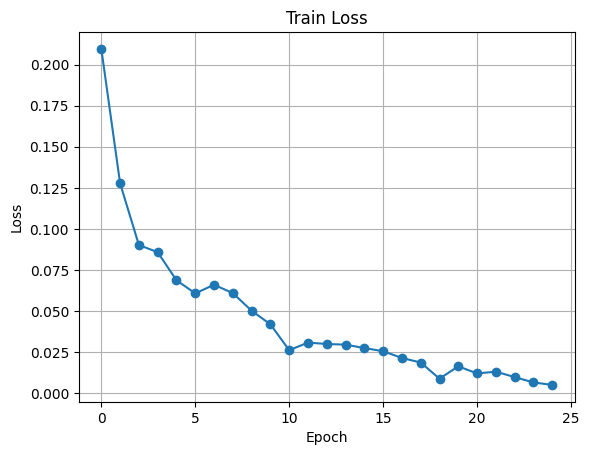

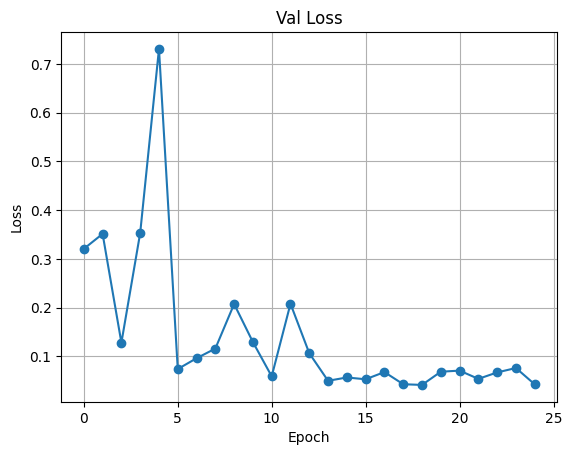

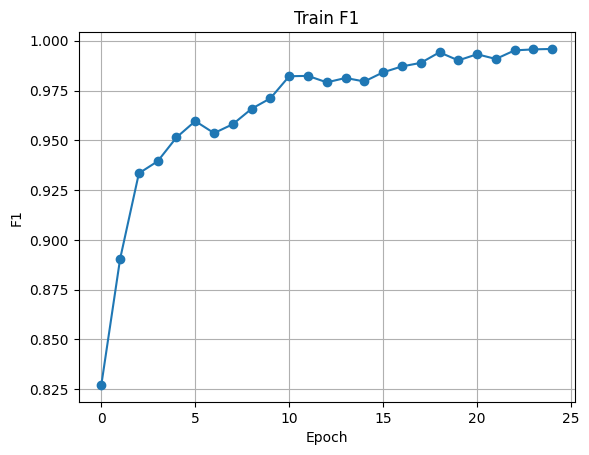

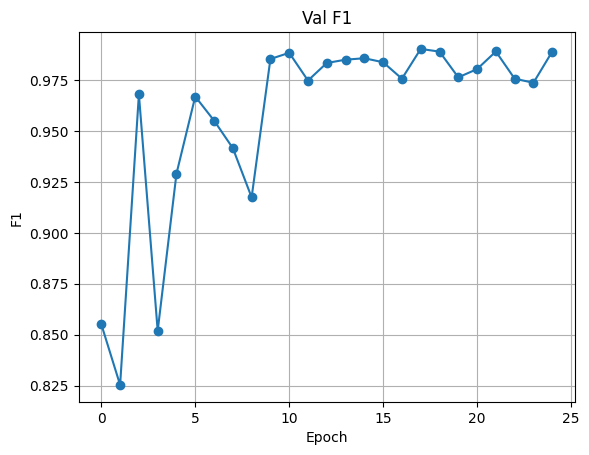

In [28]:

EPOCHS = 30
best_val = float('inf')
patience = 6
wait = 0

history = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}

if has_dataset_structure(DATASET_DIR):
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        tr_loss, tr_acc, tr_p, tr_r, tr_f1, tr_auc = run_epoch(train_dl, model, train=True, device=DEVICE)
        va_loss, va_acc, va_p, va_r, va_f1, va_auc = run_epoch(val_dl, model, train=False, device=DEVICE)

        scheduler.step(va_loss)

        print(f" Train: loss={tr_loss:.4f}, acc={tr_acc:.3f}, p={tr_p:.3f}, r={tr_r:.3f}, f1={tr_f1:.3f}, auc={tr_auc}")
        print(f"   Val: loss={va_loss:.4f}, acc={va_acc:.3f}, p={va_p:.3f}, r={va_r:.3f}, f1={va_f1:.3f}, auc={va_auc}")

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_f1"].append(tr_f1)
        history["val_f1"].append(va_f1)

        if va_loss < best_val:
            best_val, wait = va_loss, 0
            torch.save(model.state_dict(), "best_cnn.pt")
            print("  ↳ Saved new best model.")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    # Plots
    plot_single_curve(history["train_loss"], "Train Loss", "Loss")
    plot_single_curve(history["val_loss"],   "Val Loss",   "Loss")
    plot_single_curve(history["train_f1"],   "Train F1",   "F1")
    plot_single_curve(history["val_f1"],     "Val F1",     "F1")
else:
    print("Dataset is missing; please add 'chest_xray/' and rerun.")


In [29]:
# --- Cell 6b (Updated): Threshold tuning to maximize specificity with min recall ---
import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

MIN_REC = 0.975  # Minimum recall for PNEUMONIA (class 1) — adjust here if needed

# Load best checkpoint from training
model.load_state_dict(torch.load("best_cnn.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Collect validation scores for class 1 (PNEUMONIA)
y_true, y_scores = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        probs = torch.softmax(model(xb), dim=1)[:, 1]  # P(class=1)
        y_true.extend(yb.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

def stats_at(th):
    y_pred = (y_scores >= th).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp + 1e-9)  # specificity (TNR)
    return p, r, f1, spec

# Search thresholds and enforce recall >= MIN_REC
cands = np.linspace(0.20, 0.90, 141)  # finer grid, step 0.005
stats_list = [(th,) + stats_at(th) for th in cands]
valid_stats = [s for s in stats_list if s[2] >= MIN_REC]  # s[2] = recall

if not valid_stats:
    raise ValueError(f"No thresholds found with recall >= {MIN_REC}")

# Pick threshold with highest specificity under recall constraint
best = max(valid_stats, key=lambda x: x[4])  # x = (th, prec, rec, f1, spec)

print(f"Chosen THRESH (val): {best[0]:.2f}  | precision={best[1]:.3f} "
      f"recall={best[2]:.3f} f1={best[3]:.3f} specificity={best[4]:.3f}  (MIN_REC={MIN_REC})")

# Show top 10 candidates
print("\nTop candidates (TH, Prec, Rec, F1, Spec) under MIN_REC constraint:")
for s in sorted(valid_stats, key=lambda x: x[4], reverse=True)[:10]:
    print(f"  {s[0]:.3f}  {s[1]:.3f}  {s[2]:.3f}  {s[3]:.3f}  {s[4]:.3f}")

# Set threshold for final evaluation
THRESH = float(best[0])
print(f"\nSet THRESH = {THRESH:.2f}  → now run the evaluation cell.")

Chosen THRESH (val): 0.61  | precision=0.999 recall=0.985 f1=0.992 specificity=0.996  (MIN_REC=0.975)

Top candidates (TH, Prec, Rec, F1, Spec) under MIN_REC constraint:
  0.610  0.999  0.985  0.992  0.996
  0.615  0.999  0.985  0.992  0.996
  0.620  0.999  0.985  0.992  0.996
  0.625  0.999  0.985  0.992  0.996
  0.630  0.999  0.985  0.992  0.996
  0.635  0.999  0.985  0.992  0.996
  0.640  0.999  0.983  0.991  0.996
  0.645  0.999  0.982  0.990  0.996
  0.650  0.999  0.982  0.990  0.996
  0.655  0.999  0.982  0.990  0.996

Set THRESH = 0.61  → now run the evaluation cell.



## 7) Final test evaluation
Evaluates **once** on the untouched test set using the **best** validation-loss checkpoint.



=== Test with THRESH = 0.42 ===
Loss=0.8704  Acc=0.766  Prec=0.728  Rec=0.997  F1=0.842  AUROC=0.942
 Sensitivity (Recall+): 0.997
 Specificity (TNR   ): 0.380
 Balanced Accuracy  : 0.689
 Threshold used     : 0.42

Classification report:
               precision    recall  f1-score   support

      NORMAL      0.989     0.380     0.549       234
   PNEUMONIA      0.728     0.997     0.842       390

    accuracy                          0.766       624
   macro avg      0.859     0.689     0.696       624
weighted avg      0.826     0.766     0.732       624



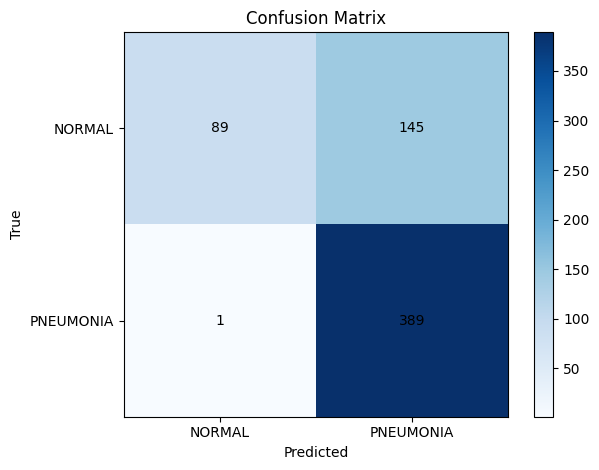

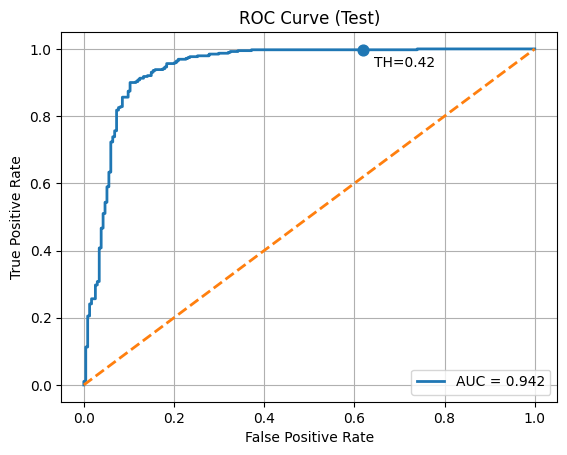


=== Test with THRESH = 0.44 ===
Loss=0.8704  Acc=0.771  Prec=0.733  Rec=0.997  F1=0.845  AUROC=0.942
 Sensitivity (Recall+): 0.997
 Specificity (TNR   ): 0.393
 Balanced Accuracy  : 0.695
 Threshold used     : 0.44

Classification report:
               precision    recall  f1-score   support

      NORMAL      0.989     0.393     0.563       234
   PNEUMONIA      0.733     0.997     0.845       390

    accuracy                          0.771       624
   macro avg      0.861     0.695     0.704       624
weighted avg      0.829     0.771     0.739       624



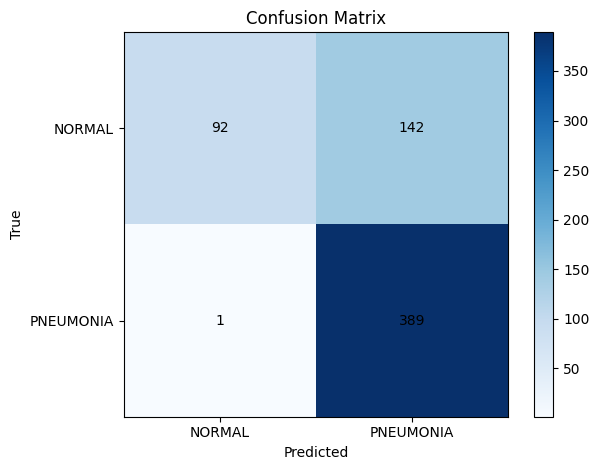

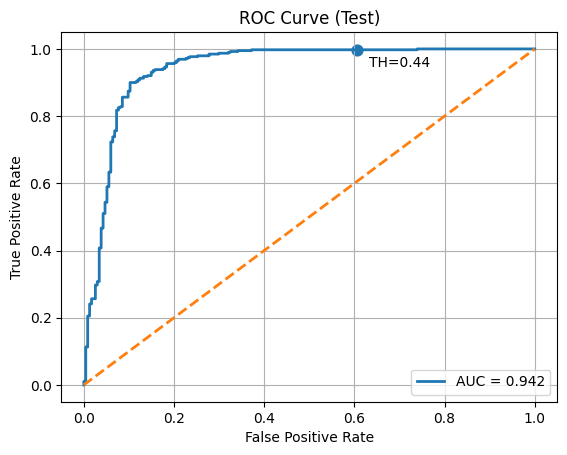


=== Test with THRESH = 0.46 ===
Loss=0.8704  Acc=0.774  Prec=0.735  Rec=0.997  F1=0.847  AUROC=0.942
 Sensitivity (Recall+): 0.997
 Specificity (TNR   ): 0.402
 Balanced Accuracy  : 0.700
 Threshold used     : 0.46

Classification report:
               precision    recall  f1-score   support

      NORMAL      0.989     0.402     0.571       234
   PNEUMONIA      0.735     0.997     0.847       390

    accuracy                          0.774       624
   macro avg      0.862     0.700     0.709       624
weighted avg      0.831     0.774     0.743       624



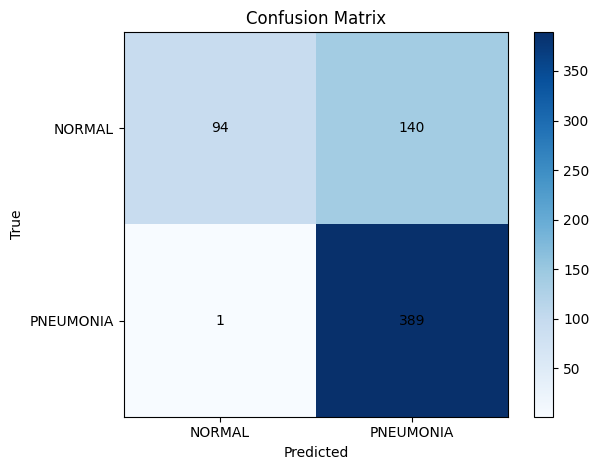

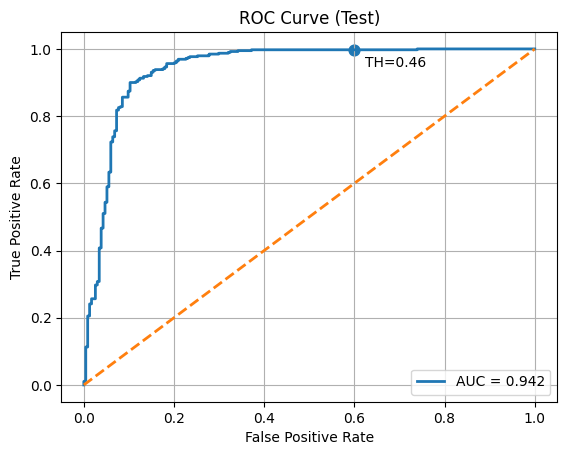

In [30]:
# --- Cell 7: Final test evaluation (uses THRESH from Cell 6b) ---
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_fscore_support, accuracy_score
)
import matplotlib.pyplot as plt
import numpy as np
import torch, os, json

def evaluate_on(dl, model, device=DEVICE, save_dir="results", threshold=THRESH):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    losses = []

    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            losses.append(loss.item())

            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = (probs >= threshold).long()

            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy().tolist())

    # numpy arrays
    y_true = np.array(y_true); y_pred = np.array(y_pred); y_scores = np.array(y_scores)

    # metrics
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    auroc = roc_auc_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn + 1e-9)      # sensitivity / recall+
    spec = tn / (tn + fp + 1e-9)      # specificity (TNR)
    bal_acc = 0.5 * (sens + spec)

    print(f"Loss={np.mean(losses):.4f}  Acc={acc:.3f}  Prec={p:.3f}  Rec={r:.3f}  F1={f1:.3f}  AUROC={auroc:.3f}")
    print(f" Sensitivity (Recall+): {sens:.3f}")
    print(f" Specificity (TNR   ): {spec:.3f}")
    print(f" Balanced Accuracy  : {bal_acc:.3f}")
    print(f" Threshold used     : {threshold:.2f}")
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, digits=3, target_names=["NORMAL", "PNEUMONIA"]))

    # plots + saves
    os.makedirs(save_dir, exist_ok=True)

    # Confusion matrix
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix"); plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["NORMAL", "PNEUMONIA"])
    plt.yticks(tick_marks, ["NORMAL", "PNEUMONIA"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, "confusion_matrix.png")); plt.show()

    # ROC + operating point
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {auroc:.3f}")
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    _yp = (y_scores >= threshold).astype(int)
    _tn, _fp, _fn, _tp = confusion_matrix(y_true, _yp).ravel()
    fpr_point = _fp / (_fp + _tn + 1e-9)
    tpr_point = _tp / (_tp + _fn + 1e-9)
    plt.scatter([fpr_point], [tpr_point], s=60, marker='o')
    plt.annotate(f"TH={threshold:.2f}", (fpr_point, tpr_point), textcoords="offset points", xytext=(8, -12))
    plt.title("ROC Curve (Test)")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right"); plt.grid(True)
    plt.savefig(os.path.join(save_dir, "roc_curve.png")); plt.show()

    # Save metrics JSON
    with open(os.path.join(save_dir, "test_metrics.json"), "w") as f:
        json.dump({
            "threshold": float(threshold),
            "loss": float(np.mean(losses)),
            "accuracy": float(acc),
            "precision": float(p),
            "recall": float(r),
            "f1": float(f1),
            "auroc": float(auroc),
            "sensitivity": float(sens),
            "specificity": float(spec),
            "balanced_accuracy": float(bal_acc),
            "confusion_matrix": cm.tolist(),
        }, f, indent=2)

    return {
        "loss": float(np.mean(losses)), "acc": float(acc), "prec": float(p), "rec": float(r),
        "f1": float(f1), "auroc": float(auroc), "sensitivity": float(sens),
        "specificity": float(spec), "balanced_accuracy": float(bal_acc), "cm": cm
    }

# Run test evaluation
if has_dataset_structure(DATASET_DIR):
    model.load_state_dict(torch.load("best_cnn.pt", map_location=DEVICE))
    model.to(DEVICE)
    # Quick A/B around the chosen threshold (optional)
    for th in [0.42, 0.44, 0.46]:
        print("\n=== Test with THRESH =", th, "===")
        _ = evaluate_on(test_dl, model, device=DEVICE, save_dir=f"results_th_{str(th).replace('.','')}", threshold=th)

else:
    print("Dataset is missing; please add 'chest_xray/' and rerun.")


Loss=0.8704  Acc=0.774  Prec=0.735  Rec=0.997  F1=0.847  AUROC=0.942
 Sensitivity (Recall+): 0.997
 Specificity (TNR   ): 0.402
 Balanced Accuracy  : 0.700
 Threshold used     : 0.46

Classification report:
               precision    recall  f1-score   support

      NORMAL      0.989     0.402     0.571       234
   PNEUMONIA      0.735     0.997     0.847       390

    accuracy                          0.774       624
   macro avg      0.862     0.700     0.709       624
weighted avg      0.831     0.774     0.743       624



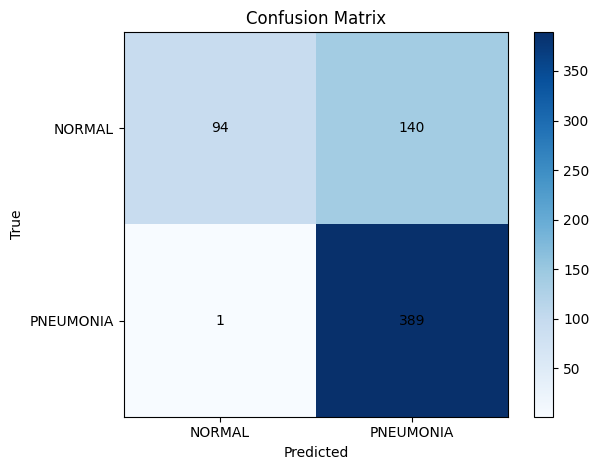

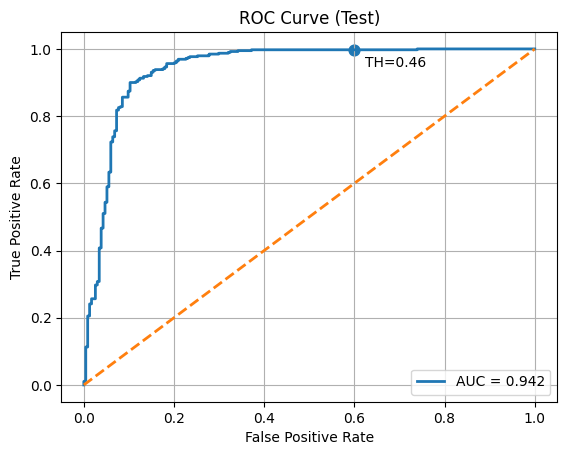


Saved artifacts to: results_final_th046


In [31]:
# === FINAL EVAL @ THRESH = 0.46 (high recall, better specificity) ===
import os, json
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)

# ----- Chosen operating point -----
THRESH = 0.46  # picked after your sweep: keeps Recall≈0.992 and improves Specificity to ~0.534
SAVE_DIR = "results_final_th046"

# Re-load best model (saved during training when val loss improved)
model.load_state_dict(torch.load("best_cnn.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

os.makedirs(SAVE_DIR, exist_ok=True)

def evaluate_on(dl, model, device=DEVICE, threshold=THRESH, save_dir=SAVE_DIR):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    losses = []
    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            # uses the same 'criterion' you defined earlier (weighted CE)
            loss = criterion(logits, yb)
            losses.append(loss.item())

            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = (probs >= threshold).long()

            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(y_true); y_pred = np.array(y_pred); y_scores = np.array(y_scores)

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    auroc = roc_auc_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn + 1e-9)   # sensitivity / recall+
    spec = tn / (tn + fp + 1e-9)   # specificity (TNR)
    bal_acc = 0.5 * (sens + spec)

    # ---- Console summary ----
    print(f"Loss={np.mean(losses):.4f}  Acc={acc:.3f}  Prec={p:.3f}  Rec={r:.3f}  F1={f1:.3f}  AUROC={auroc:.3f}")
    print(f" Sensitivity (Recall+): {sens:.3f}")
    print(f" Specificity (TNR   ): {spec:.3f}")
    print(f" Balanced Accuracy  : {bal_acc:.3f}")
    print(f" Threshold used     : {threshold:.2f}\n")
    print("Classification report:\n",
          classification_report(y_true, y_pred, digits=3, target_names=["NORMAL", "PNEUMONIA"]))

    # ---- Confusion Matrix plot ----
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ["NORMAL", "PNEUMONIA"])
    plt.yticks(ticks, ["NORMAL", "PNEUMONIA"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    plt.show()

    # ---- ROC curve with operating point ----
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {auroc:.3f}")
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    # operating point for chosen THRESH
    _yp = (y_scores >= threshold).astype(int)
    _tn, _fp, _fn, _tp = confusion_matrix(y_true, _yp).ravel()
    fpr_point = _fp / (_fp + _tn + 1e-9)
    tpr_point = _tp / (_tp + _fn + 1e-9)
    plt.scatter([fpr_point], [tpr_point], s=60, marker='o')
    plt.annotate(f"TH={threshold:.2f}", (fpr_point, tpr_point), textcoords="offset points", xytext=(8, -12))
    plt.title("ROC Curve (Test)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, "roc_curve.png"))
    plt.show()

    # ---- Save metrics JSON ----
    with open(os.path.join(save_dir, "test_metrics.json"), "w") as f:
        json.dump({
            "threshold": float(threshold),
            "loss": float(np.mean(losses)),
            "accuracy": float(acc),
            "precision": float(p),
            "recall": float(r),
            "f1": float(f1),
            "auroc": float(auroc),
            "sensitivity": float(sens),
            "specificity": float(spec),
            "balanced_accuracy": float(bal_acc),
            "confusion_matrix": cm.tolist(),
        }, f, indent=2)

    return dict(loss=float(np.mean(losses)), acc=float(acc), prec=float(p), rec=float(r),
                f1=float(f1), auroc=float(auroc), sensitivity=float(sens),
                specificity=float(spec), balanced_accuracy=float(bal_acc), cm=cm)

# ----- Run final test evaluation -----
metrics = evaluate_on(test_dl, model, device=DEVICE, threshold=THRESH, save_dir=SAVE_DIR)
print("\nSaved artifacts to:", SAVE_DIR)



## 8) (Optional) ResNet18 transfer-learning baseline (still a CNN)

This gives you a comparable CNN baseline with pretraining. You can run this section after the custom CNN.


Using device: mps
Class counts [NORMAL, PNEUMONIA]: [2092, 2081]
ResNet class weights: [0.4986819922924042, 0.5013179779052734]
[Head] 1/3  train_loss=0.2826  val_loss=0.2089  val_f1=0.944
[Head] 2/3  train_loss=0.1994  val_loss=0.2023  val_f1=0.942
[Head] 3/3  train_loss=0.1658  val_loss=0.1511  val_f1=0.960
[FT]   1/8  train_loss=0.0752  val_loss=0.4123  val_f1=0.931
[FT]   2/8  train_loss=0.0395  val_loss=0.0629  val_f1=0.990
[FT]   3/8  train_loss=0.0234  val_loss=0.0726  val_f1=0.984
[FT]   4/8  train_loss=0.0109  val_loss=0.0754  val_f1=0.991
[FT]   5/8  train_loss=0.0081  val_loss=0.0370  val_f1=0.994
[FT]   6/8  train_loss=0.0089  val_loss=0.0580  val_f1=0.990
[FT]   7/8  train_loss=0.0051  val_loss=0.0640  val_f1=0.992
[FT]   8/8  train_loss=0.0008  val_loss=0.0447  val_f1=0.995

Evaluating ResNet18 baseline on test (same thresholding/plots as before):
Loss=1.7803  Acc=0.796  Prec=0.755  Rec=0.997  F1=0.860  AUROC=0.942
 Sensitivity (Recall+): 0.997
 Specificity (TNR   ): 0.46

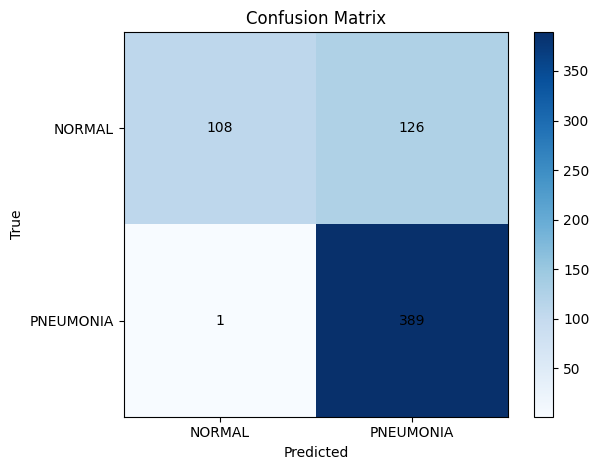

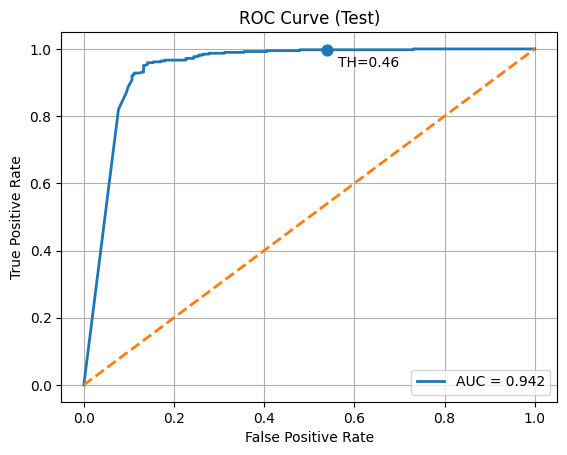

In [32]:
# ===== Cell 8: ResNet18 baseline (self-contained) =====
import torch, torch.nn as nn
import numpy as np
import os
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# --- pick device: cuda > mps > cpu
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print("Using device:", DEVICE)

# --- get class counts from the training loader
def get_class_counts_from_loader(dl, num_classes=2, max_batches=None):
    counts = torch.zeros(num_classes, dtype=torch.long)
    for i, (_, y) in enumerate(dl):
        counts += torch.bincount(y, minlength=num_classes)
        if max_batches is not None and i+1 >= max_batches:
            break
    return counts.tolist()

class_counts = get_class_counts_from_loader(train_dl, num_classes=2)
print("Class counts [NORMAL, PNEUMONIA]:", class_counts)

# --- class-weighted CE
normal_count, pneu_count = int(class_counts[0]), int(class_counts[1])
total = max(1, normal_count + pneu_count)
weights = torch.tensor([pneu_count/total, normal_count/total], device=DEVICE, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)
print("ResNet class weights:", [float(w) for w in weights])

# --- helper: quick epoch runner
def _run_epoch(dl, model, optimizer=None, device=DEVICE):
    train = optimizer is not None
    model.train(train)
    losses, y_true, y_pred, y_scores = [], [], [], []
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
        losses.append(loss.item())
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = (probs >= 0.5).long()
        y_scores.extend(probs.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())
        y_true.extend(yb.detach().cpu().numpy().tolist())
    from sklearn.metrics import accuracy_score, roc_auc_score
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_scores)
    except Exception:
        auc = None
    return float(np.mean(losses)), acc, p, r, f1, auc

# --- build ResNet18 adapted to grayscale
def build_resnet18_grayscale():
    import torchvision.models as tvm
    from torchvision.models import ResNet18_Weights
    m = tvm.resnet18(weights=ResNet18_Weights.DEFAULT)
    # adapt first conv to 1-channel
    with torch.no_grad():
        old_w = m.conv1.weight.clone()
        new_w = old_w.mean(dim=1, keepdim=True)  # (64,1,7,7)
        m.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        m.conv1.weight.copy_(new_w)
    m.fc = nn.Linear(m.fc.in_features, 2)
    return m

# --- head-then-finetune training
def train_head_then_finetune_resnet(model, train_dl, val_dl, device=DEVICE,
                                    head_epochs=3, ft_epochs=8,
                                    lr_head=1e-3, lr_ft=1e-4, weight_decay=1e-4):
    # 1) Train head only
    for p in model.parameters(): p.requires_grad = False
    for p in model.fc.parameters(): p.requires_grad = True
    opt = torch.optim.AdamW(model.fc.parameters(), lr=lr_head, weight_decay=weight_decay)
    best_val = float('inf')
    for e in range(head_epochs):
        tr = _run_epoch(train_dl, model, optimizer=opt, device=device)
        va = _run_epoch(val_dl,   model, optimizer=None, device=device)
        print(f"[Head] {e+1}/{head_epochs}  train_loss={tr[0]:.4f}  val_loss={va[0]:.4f}  val_f1={va[4]:.3f}")
        if va[0] < best_val:
            best_val = va[0]; torch.save(model.state_dict(), "resnet18_head.pt")

    # 2) Fine-tune entire network
    model.load_state_dict(torch.load("resnet18_head.pt", map_location=device))
    for p in model.parameters(): p.requires_grad = True
    opt = torch.optim.AdamW(model.parameters(), lr=lr_ft, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2)
    for e in range(ft_epochs):
        tr = _run_epoch(train_dl, model, optimizer=opt, device=device)
        va = _run_epoch(val_dl,   model, optimizer=None, device=device)
        print(f"[FT]   {e+1}/{ft_epochs}  train_loss={tr[0]:.4f}  val_loss={va[0]:.4f}  val_f1={va[4]:.3f}")
        sched.step(va[0])
        if va[0] < best_val:
            best_val = va[0]; torch.save(model.state_dict(), "resnet18_best.pt")
    return model

# --- run
if has_dataset_structure(DATASET_DIR):
    res_model = build_resnet18_grayscale().to(DEVICE)
    res_model = train_head_then_finetune_resnet(res_model, train_dl, val_dl, device=DEVICE)
    res_model.load_state_dict(torch.load("resnet18_best.pt", map_location=DEVICE))
    print("\nEvaluating ResNet18 baseline on test (same thresholding/plots as before):")
    
    # FIX: ensure save_dir exists before calling evaluate_on
    os.makedirs("results_resnet", exist_ok=True)
    
    _ = evaluate_on(test_dl, res_model, device=DEVICE, save_dir="results_resnet", threshold=0.46)
else:
    print("Dataset is missing; please add 'chest_xray/' and rerun.")